# Fastai v2 with image, text, and tabular data

* [Fastai v2](https://www.fast.ai/2020/08/21/fastai2-launch/) was launched on August 21st, 2020 along with a companion textbook and a companion course.  Much of this work is adapted from the official fast.ai courses and tutorials.  For more detail about fastai, see https://www.mdpi.com/2078-2489/11/2/108/htm.  I highly recommend these free learning materials:  

 - https://www.fast.ai/2020/08/21/fastai2-launch/ 
 - https://docs.fast.ai/tutorial


* The purpose of this notebook is to demonstrate how to use a GPU-enabled Kaggle Notebook to train a ML model using the recently released fastai-v2.  
* Note that this method uses the default Kaggle docker image and does not require any pip install statements.


In [1]:
import torch
import fastai
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai import *

import time
from datetime import datetime

print(f'Notebook last run on {datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d, %H:%M:%S UTC")}')
print('Using fastai version ',fastai.__version__)
print('And torch version ',torch.__version__)

Notebook last run on 2020-09-23, 19:35:05 UTC
Using fastai version  2.0.13
And torch version  1.6.0


In [2]:
def plot_fastai_results(learn):
    '''
    Plots sensitivity, speficificty, prevalence, accuracy, and confusion matrix for a fastai model named "learn".
    Some portions are adapted from https://github.com/fastai/fastai/blob/master/nbs/61_tutorial.medical_imaging.ipynb
    '''
    interp = Interpretation.from_learner(learn)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(7,7))
    losses,idxs = interp.top_losses()
    len(dls.valid_ds)==len(losses)==len(idxs)
    upp, low = interp.confusion_matrix()
    tn, fp = upp[0], upp[1]
    fn, tp = low[0], low[1]
    sensitivity = tp/(tp + fn)
    print('Sensitivity: ',sensitivity)
    specificity = tn/(fp + tn)
    print('Specificity: ',specificity)
    #val = dls.valid_ds.cat
    prevalance = 15/50
    print('Prevalance: ',prevalance)
    accuracy = (sensitivity * prevalance) + (specificity * (1 - prevalance))
    print('Accuracy: ',accuracy)

# Image data from fastai
* This is a small dataset of chest x-ray images

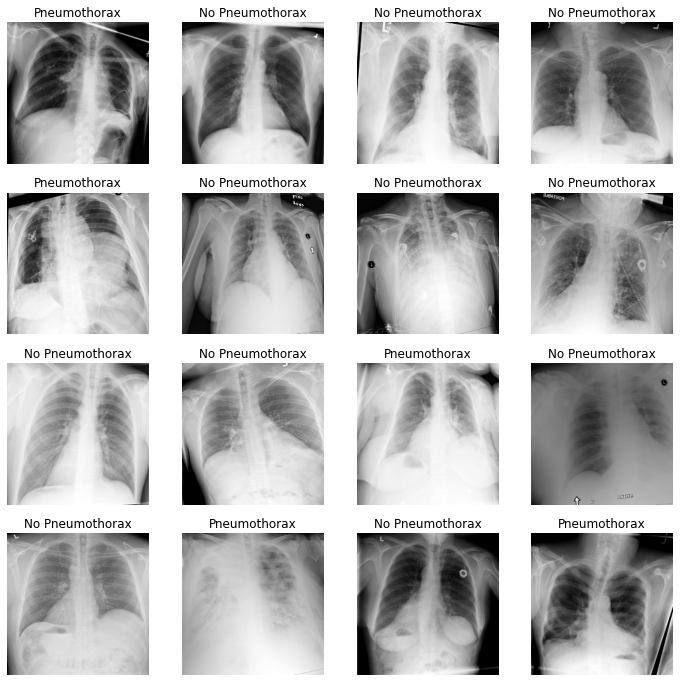

In [3]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)
items = get_dicom_files(pneumothorax_source/f"train/")
trn,val = RandomSplitter()(items)
df = pd.read_csv(pneumothorax_source/f"labels.csv")
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=224))
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.345660,1.031492,0.640000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.109336,0.640274,0.680000,00:03
1,1.025633,0.688715,0.640000,00:03
2,0.980937,0.842725,0.540000,00:02
3,0.926489,0.854856,0.600000,00:03
4,0.890824,0.893003,0.580000,00:03


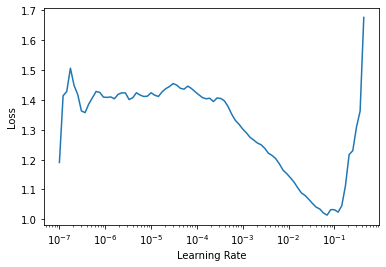

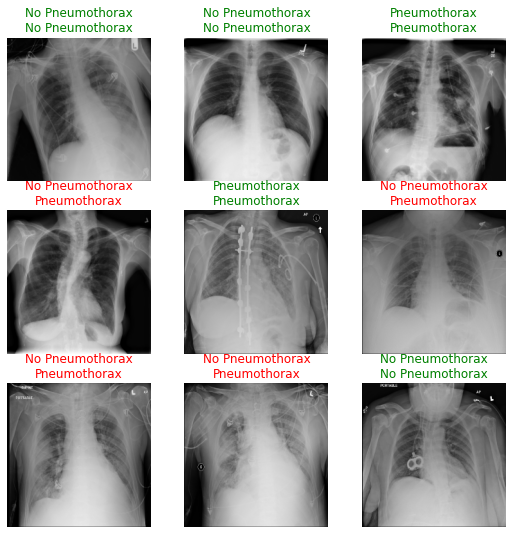

In [4]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, model_dir='/kaggle/tmp/model/')
learn.lr_find()
learn.fine_tune(5)
learn.show_results()

Sensitivity:  0.7058823529411765
Specificity:  0.5151515151515151
Prevalance:  0.3
Accuracy:  0.5723707664884136


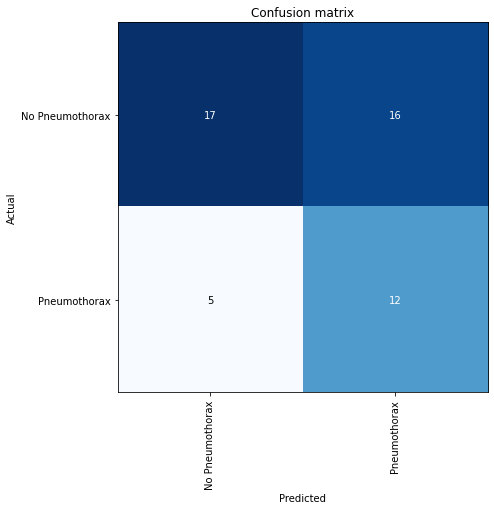

In [5]:
plot_fastai_results(learn=learn)

# Image data from Kaggle
* This dataset has a lot more images than the previous dataset.  This should improve the accuracy of our model.

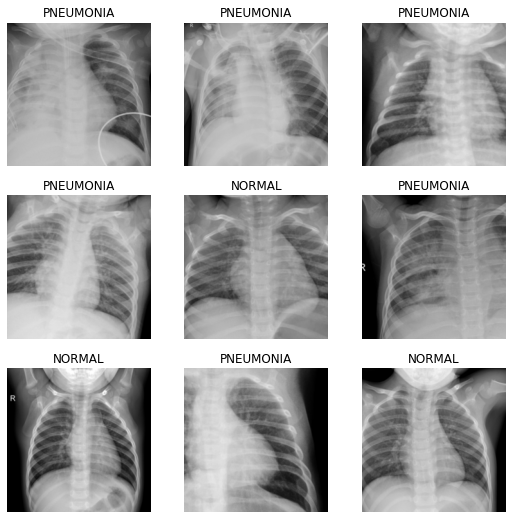

In [6]:
path = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/')
dls = ImageDataLoaders.from_folder(path, train='train',
                                   item_tfms=Resize(224),valid_pct=0.2,
                                   bs=64,seed=0)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,0.332375,0.185303,0.946627,02:59


epoch,train_loss,valid_loss,accuracy,time
0,0.130189,0.080099,0.974381,02:52
1,0.086451,0.087058,0.973100,02:55
2,0.049491,0.053779,0.984202,02:53
3,0.025360,0.045544,0.988471,02:52
4,0.012665,0.035806,0.990179,02:55


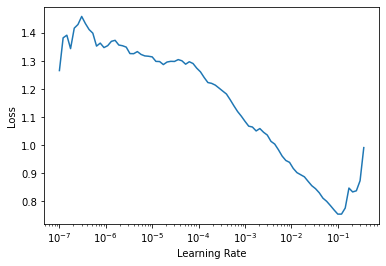

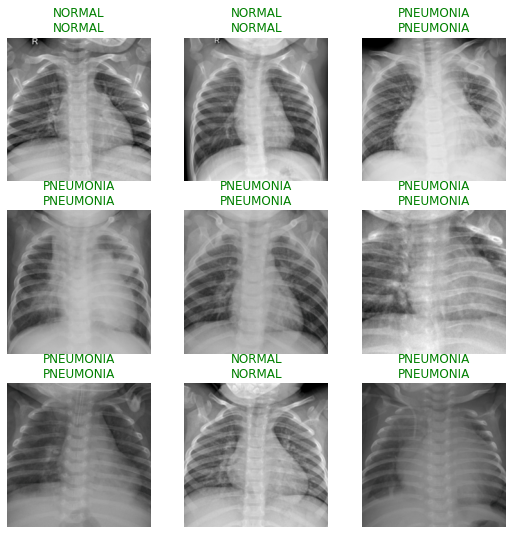

In [7]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, model_dir='/kaggle/tmp/model/')
learn.lr_find()
learn.fine_tune(5)
learn.show_results()

Sensitivity:  0.9953216374269006
Specificity:  0.9762658227848101
Prevalance:  0.3
Accuracy:  0.9819825671774373


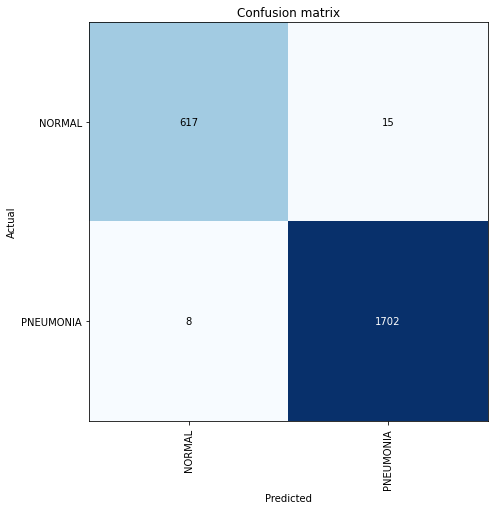

In [8]:
plot_fastai_results(learn=learn)

# Tabular data from fastai

In [9]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,False,68.000002,76370.996885,9.0,>=50k
1,Private,Bachelors,Divorced,Craft-repair,Unmarried,White,False,34.000000,97306.003029,13.0,<50k
2,Private,7th-8th,Never-married,Machine-op-inspct,Own-child,White,False,26.000000,212303.999820,4.0,<50k
3,Federal-gov,Bachelors,Divorced,Prof-specialty,Unmarried,White,False,39.000000,193583.000004,13.0,<50k
4,Private,5th-6th,Married-spouse-absent,Other-service,Unmarried,White,False,50.000000,263200.002656,3.0,<50k
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,False,18.000001,135923.999872,10.0,<50k
6,Private,Some-college,Never-married,Other-service,Own-child,Black,False,18.000001,120690.999550,10.0,<50k
7,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,False,57.000000,124999.998176,15.0,>=50k
8,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,False,57.000000,180210.999840,15.0,>=50k
9,Private,HS-grad,Separated,Craft-repair,Unmarried,White,False,31.000000,442429.011983,9.0,<50k


epoch,train_loss,valid_loss,accuracy,time
0,0.371470,0.370820,0.823556,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.347662,0.366039,0.827088,00:05
1,0.349320,0.357688,0.830620,00:05
2,0.335386,0.358858,0.830006,00:05
3,0.342068,0.358019,0.829699,00:05
4,0.326586,0.357572,0.829699,00:05


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,10.0,5.0,5.0,2.0,5.0,1.0,1.288590,0.989483,1.146471,1.0,0.0
1,5.0,12.0,4.0,6.0,2.0,5.0,1.0,0.553139,-0.448238,-0.419058,0.0,0.0
2,5.0,12.0,6.0,9.0,2.0,5.0,1.0,-0.917762,1.321630,-0.419058,0.0,0.0
3,7.0,10.0,3.0,5.0,1.0,5.0,1.0,0.479594,0.332558,1.146471,1.0,1.0
4,5.0,12.0,5.0,6.0,2.0,5.0,1.0,-0.550036,3.029988,-0.419058,0.0,0.0
5,5.0,12.0,3.0,5.0,1.0,5.0,1.0,0.847319,0.056769,-0.419058,1.0,1.0
6,5.0,16.0,5.0,4.0,4.0,2.0,1.0,0.185414,-1.017539,-0.027676,0.0,0.0
7,3.0,8.0,3.0,7.0,1.0,5.0,1.0,0.479594,-0.189850,0.755089,0.0,0.0
8,5.0,10.0,5.0,5.0,2.0,5.0,1.0,-0.623581,-0.699085,1.146471,1.0,0.0


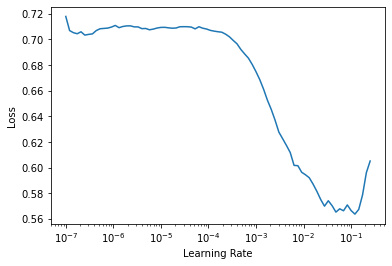

In [10]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()
learn.fine_tune(5)
learn.show_results()

Sensitivity:  0.5495327102803739
Specificity:  0.9213368657020583
Prevalance:  0.3
Accuracy:  0.8097956190755529


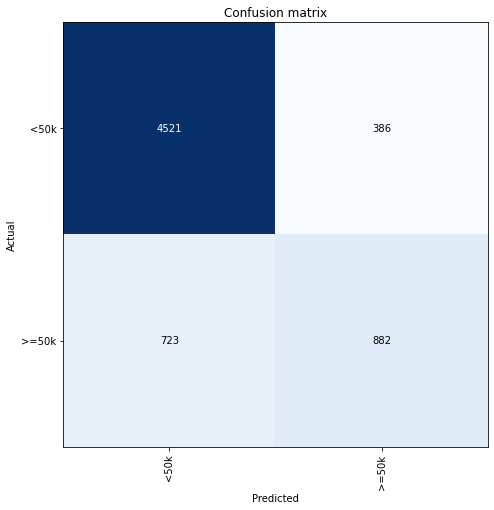

In [11]:
plot_fastai_results(learn=learn)

# Tabular Data from Kaggle

In [12]:
df = pd.read_csv('/kaggle/input/adult-census-income/adult.csv', skipinitialspace=True)
dls = TabularDataLoaders.from_df(df=df, path=path, y_names="income",
    cat_names = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education.num'],
    procs = [Categorify, FillMissing, Normalize])
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education.num'],
                   y_names='income',
                   splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()

,workclass,education,marital.status,occupation,relationship,race,age,fnlwgt,education.num,income
0,Federal-gov,HS-grad,Never-married,Handlers-cleaners,Own-child,White,31.0,101345.002895,9.0,<=50K
1,Private,Some-college,Never-married,Exec-managerial,Not-in-family,White,40.0,236021.000742,10.0,<=50K
2,Private,HS-grad,Never-married,Sales,Not-in-family,Asian-Pac-Islander,44.0,81853.000281,9.0,<=50K
3,Federal-gov,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,52.0,207841.000697,10.0,<=50K
4,Federal-gov,Assoc-acdm,Married-civ-spouse,Adm-clerical,Husband,Black,47.0,282829.996979,12.0,>50K
5,Private,5th-6th,Never-married,Priv-house-serv,Own-child,White,47.0,185253.999973,3.0,<=50K
6,Federal-gov,HS-grad,Divorced,Machine-op-inspct,Not-in-family,White,44.0,161239.999536,9.0,<=50K
7,Self-emp-inc,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,43.0,62026.003255,15.0,>50K
8,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,25.0,161007.001511,9.0,<=50K
9,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,48.0,138969.998640,13.0,>50K


epoch,train_loss,valid_loss,accuracy,time
0,0.368699,0.364438,0.830467,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.346603,0.361915,0.836302,00:05
1,0.343241,0.362565,0.834152,00:05
2,0.348667,0.359596,0.835381,00:05
3,0.338114,0.357881,0.837684,00:05
4,0.342685,0.358663,0.838759,00:05


,workclass,education,marital.status,occupation,relationship,race,age,fnlwgt,education.num,income,income_pred
0,5.0,16.0,5.0,11.0,2.0,5.0,-1.288062,-0.685758,-0.029077,0.0,0.0
1,3.0,12.0,7.0,9.0,5.0,1.0,3.030056,-1.606754,-0.417303,0.0,0.0
2,3.0,10.0,1.0,11.0,2.0,5.0,-0.482989,-1.394275,1.135602,0.0,0.0
3,5.0,12.0,3.0,12.0,1.0,5.0,0.395272,-0.024772,-0.417303,0.0,0.0
4,5.0,12.0,5.0,2.0,4.0,5.0,-1.361251,0.151209,-0.417303,0.0,0.0
5,1.0,6.0,5.0,1.0,2.0,5.0,-1.141685,0.226991,-2.358434,0.0,0.0
6,5.0,13.0,3.0,14.0,1.0,5.0,1.200345,0.171007,1.523828,1.0,1.0
7,5.0,2.0,5.0,13.0,5.0,3.0,-0.409801,1.142801,-1.193756,0.0,0.0
8,5.0,1.0,1.0,15.0,5.0,5.0,-0.190235,-0.052439,-1.581982,0.0,0.0


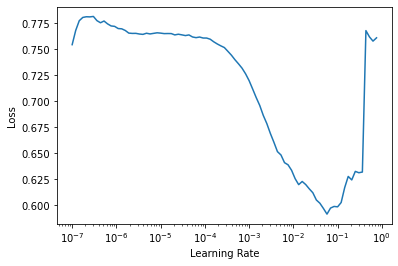

In [13]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()
learn.fine_tune(5)
learn.show_results()

Sensitivity:  0.5665236051502146
Specificity:  0.9297275148535136
Prevalance:  0.3
Accuracy:  0.8207663419425238


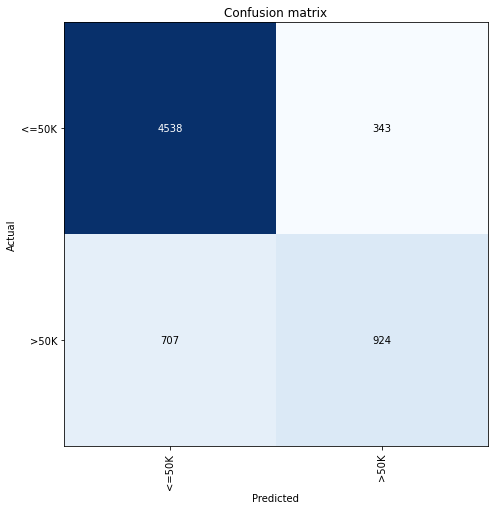

In [14]:
plot_fastai_results(learn=learn)

# Text data from fastai
* IMDB Film Reviews, pos or neg

In [15]:
path = untar_data(URLs.IMDB)
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
dls.show_batch(max_n=3) # investigate https://forums.fast.ai/t/most-of-the-items-in-show-batch-is-xxpad-strings/78989

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,pos
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,neg


epoch,train_loss,valid_loss,accuracy,time
0,0.599038,0.400042,0.816840,02:20


epoch,train_loss,valid_loss,accuracy,time
0,0.456405,0.298754,0.875480,04:19
1,0.344929,0.253174,0.896920,04:20
2,0.292500,0.226914,0.909120,04:18
3,0.259644,0.219611,0.913200,04:19
4,0.246008,0.212598,0.914880,04:18
5,0.220676,0.209066,0.918080,04:18
6,0.213737,0.209138,0.919040,04:18


,text,category,category_
0,"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that says : \n\n * major xxup spoilers xxup ahead * \n\n ( but you already knew that , did n't you ? ) \n\n xxmaj since there 's a great deal of people that apparently did not get the point of this movie , xxmaj i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of this movie is not sufficient . xxmaj if you have the xxup dvd of xxup md , you can "" cheat "" by looking at xxmaj david xxmaj lynch 's "" top 10 xxmaj hints to xxmaj unlocking xxup md "" ( but only upon second or third viewing , please . ) ;) \n\n xxmaj first of all , xxmaj mulholland xxmaj drive is",pos,pos
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,pos,neg
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,neg,neg


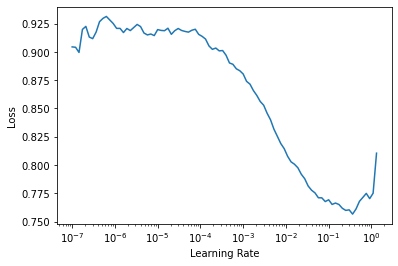

In [16]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.lr_find()
learn.fine_tune(7)
learn.show_results(max_n=3)

Sensitivity:  0.9156
Specificity:  0.92248
Prevalance:  0.3
Accuracy:  0.9204159999999999


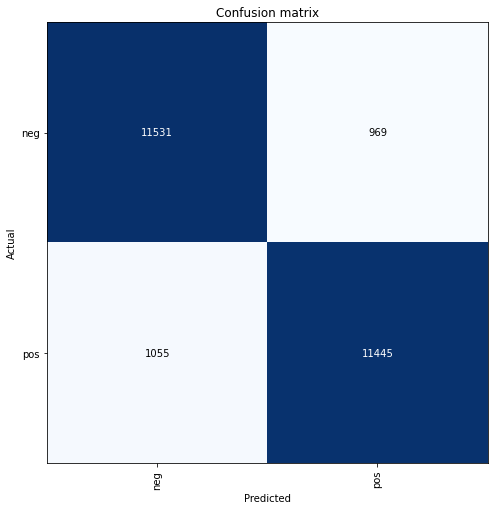

In [17]:
plot_fastai_results(learn=learn)

# Text data from Kaggle
* IMDB Film Reviews, positive or negative

In [18]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
dls = TextDataLoaders.from_df(df=df,model_dir='/kaggle/tmp/model/')
#dls.show_batch() # investigate https://forums.fast.ai/t/most-of-the-items-in-show-batch-is-xxpad-strings/78989/5
df.head(15)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like ""dressed-up midgets"" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling....",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gunsmoke were my hero's every week.You have my vote for a comeback of a new sea hunt.We need a change o

epoch,train_loss,valid_loss,accuracy,time
0,0.586195,0.383983,0.825600,02:25


epoch,train_loss,valid_loss,accuracy,time
0,0.389666,0.277441,0.883700,05:30
1,0.282786,0.245097,0.900100,05:30
2,0.247746,0.212509,0.913500,05:30
3,0.229579,0.206132,0.916900,05:30
4,0.212938,0.201382,0.919900,05:32


,text,category,category_
0,"xxbos xxmaj some have praised xxunk xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older adventure movies has been done well before , ( think xxmaj the xxmaj dirty xxmaj dozen ) but -atlantis- represents one of the worse films in that motif . xxmaj the characters are weak . xxmaj even the background that each member trots out seems stock and awkward at best . xxmaj an xxup md / xxmaj medicine xxmaj man , a tomboy mechanic whose father always wanted sons , if we have not at least seen these before ,",negative,negative
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,negative
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,negative


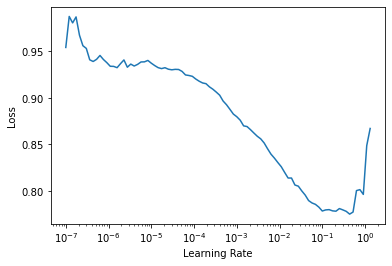

In [19]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.lr_find()
learn.fine_tune(5)
learn.show_results(max_n=3) # investigate https://forums.fast.ai/t/most-of-the-items-in-show-batch-is-xxpad-strings/78989/2

Sensitivity:  0.9177755710029791
Specificity:  0.9220543806646526
Prevalance:  0.3
Accuracy:  0.9207707377661505


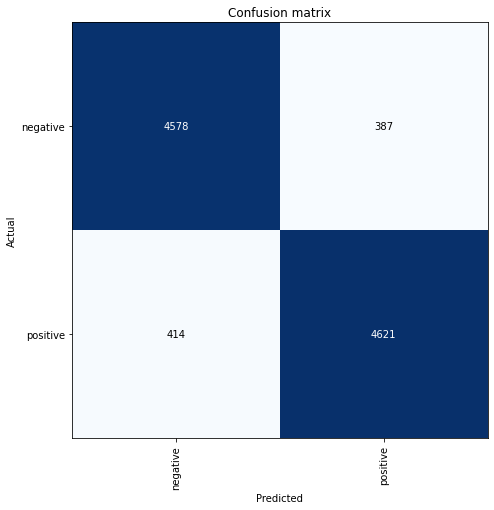

In [20]:
plot_fastai_results(learn=learn)

# References

**Tutorials and code snippets:**

 - https://docs.fast.ai/tutorial
 
  - http://docs.fast.ai/tutorial.tabular
  - http://docs.fast.ai/tutorial.text
  - http://docs.fast.ai/tutorial.vision
  
    - https://github.com/fastai/fastai/blob/master/nbs/61_tutorial.medical_imaging.ipynb

**Datasets:**

 - From fastai:

  - Filice R et al. "Crowdsourcing pneumothorax annotations using machine learning annotations on the NIH chest X-ray dataset". J Digit Imaging (2019). https://doi.org/10.1007/s10278-019-00299-9
  - Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid". Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (1996).  https://doi.org/10.4304/jcp.6.7.1325-1331
  - Maas, Andrew L., Daly, Raymond E., Pham, Peter T., Huang, Dan, Ng, Andrew Y, Potts, Christopher.  "Learning Word Vectors for Sentiment Analysis". Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies.  (2011).   https://www.aclweb.org/anthology/P11-1015
  
 
 - From kaggle:
 
  - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
  - https://www.kaggle.com/uciml/adult-census-income
  - https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [21]:
!mkdir /kaggle/working/docker/
!pip freeze > '../working/docker/requirements.txt'